In [1]:
# Master jupyter notebook for Case Study

In [2]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import datetime
from forex_python.converter import CurrencyRates
from forex_python.converter import RatesNotAvailableError

In [3]:
# extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [4]:
# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(client.isnull().sum()) # missing values in Age and Job
print(client_products.isnull().sum()) # no missing values
print(inv_campaign_eval.isnull().sum()) # no missing values
print(balances.isnull().sum()) # no missing values

# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object
client_id      0
age          232
job          438
marital        0
education      0
gender         0
dtype: int64
client_id        0
has_deposits     0
loan             0
has_insurance    0
has_mortgage     0
dtype: int64
client_id    0
poutcome     0
dtype: int64
date         0
balance      0
client_id    0
currency     0
dtype: int64


In [5]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [6]:
# extracting encoding labels for future reference
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [7]:
# editing table balances
# removing time from datetime
balances['date'] = pd.to_datetime(balances['date'])
balances['date'] = balances['date'].dt.date

# fetching currency exchange rates for EUR and USD
c = CurrencyRates()

dates = balances['date'].drop_duplicates()
target_currency = 'CZK'

# EUR
base_currency = 'EUR'

eur_rates_date = []
eur_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    eur_rates_date.append(date)
    eur_rates_rate.append(rate)

eur_df = pd.DataFrame({'date': eur_rates_date, 'eur_rate': eur_rates_rate})

# USD
base_currency = 'USD'

usd_rates_date = []
usd_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    usd_rates_date.append(date)
    usd_rates_rate.append(rate)

usd_df = pd.DataFrame({'date': usd_rates_date, 'usd_rate': usd_rates_rate})

# mapping exchange rate columns into balances dataframe
balances = pd.merge(balances, eur_df, on = 'date')
balances = pd.merge(balances, usd_df, on = 'date')

In [8]:
# creating column with balances recalculated to czk
for index, row in balances.iterrows():
    if row['currency'] == 'EUR':
        balances.at[index, 'fx_rate'] = balances.at[index, 'eur_rate']
    elif row['currency'] == 'USD':
        balances.at[index, 'fx_rate'] = balances.at[index, 'usd_rate']
    else:
        balances.at[index, 'fx_rate'] = 1

balances['balance_in_czk'] = balances['balance']*balances['fx_rate']

In [9]:
# feature engineering from table balances

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance_in_czk': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance_in_czk'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance_in_czk': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance_in_czk'].min().reset_index()
min_bal_by_client.rename(columns={'balance_in_czk': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance_in_czk'].max().reset_index()
max_bal_by_client.rename(columns={'balance_in_czk': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

# currency (encoded)
clients_merged = pd.merge(clients_merged, balances[['client_id','currency']].drop_duplicates(), on = 'client_id')
clients_merged['currency_enc'] = le.fit_transform(clients_merged['currency'])
currency_labels = clients_merged[['currency', 'currency_enc']].drop_duplicates().sort_values('currency_enc')

In [10]:
# editing evaluation table 
inv_campaign_eval['poutcome_enc'] = le.fit_transform(inv_campaign_eval['poutcome'])

first_round_clients = clients_merged[['client_id', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
first_round_clients = pd.merge(inv_campaign_eval[['client_id','poutcome_enc']], first_round_clients, on = 'client_id')
first_round_clients['age'] = first_round_clients['age'].astype(int)
first_round_clients


,client_id,poutcome_enc,age,has_deposits_enc,loan_enc,has_insurance_enc,has_mortgage_enc,marital_enc,education_enc,gender_enc,job_enc,last_balance,mean_balance,min_balance,max_balance,currency_enc
0,249789938,1,38,1,0,0,0,1,1,1,7,2680.467773,2669.532734,2515.500059,2775.615374,0
1,1504633819,0,38,0,1,0,1,1,2,1,4,5476.241582,5440.862334,5344.385346,5529.866975,0
2,1952195738,1,34,1,1,0,0,1,1,1,7,2935.906506,2922.958852,2852.824056,3016.314818,0
3,989726384,1,62,1,0,0,0,1,1,0,5,3042.641066,3124.614843,3011.445910,3212.174671,0
4,1971878545,0,36,1,0,0,0,2,2,1,4,526.157661,474.083033,362.809777,571.028715,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,1270855655,0,58,1,0,1,1,0,1,0,0,3353.741381,3349.398115,3245.043023,3445.072323,0
2295,471724023,1,72,1,0,0,0,1,0,1,5,4617.207488,4645.473515,4493.914363,4736.613098,0
2296,620088171,0,34,1,0,1,1,1,2,0,0,939.603482,895.455390,771.707441,979.161966,0
2297,1518319265,1,39,1,0,0,0,1,3,0,4,10.524798,77.494621,-36.431915,226.953215,0


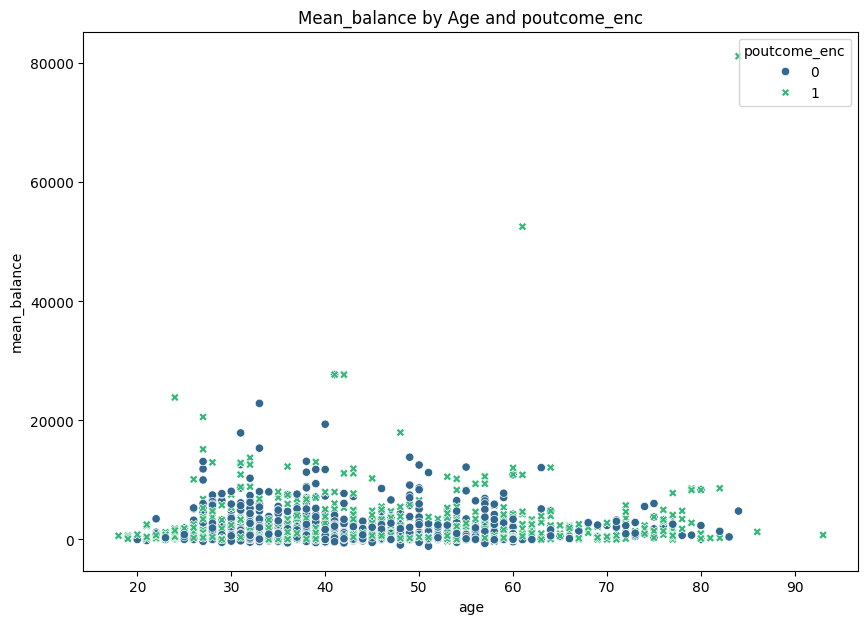

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Age versus Fare, colored by Survival
plt.figure(figsize=(10, 7))
sns.scatterplot(data=first_round_clients, x='age', y='mean_balance', hue='poutcome_enc', style='poutcome_enc', palette='viridis')
plt.title('Mean_balance by Age and poutcome_enc')
plt.show()

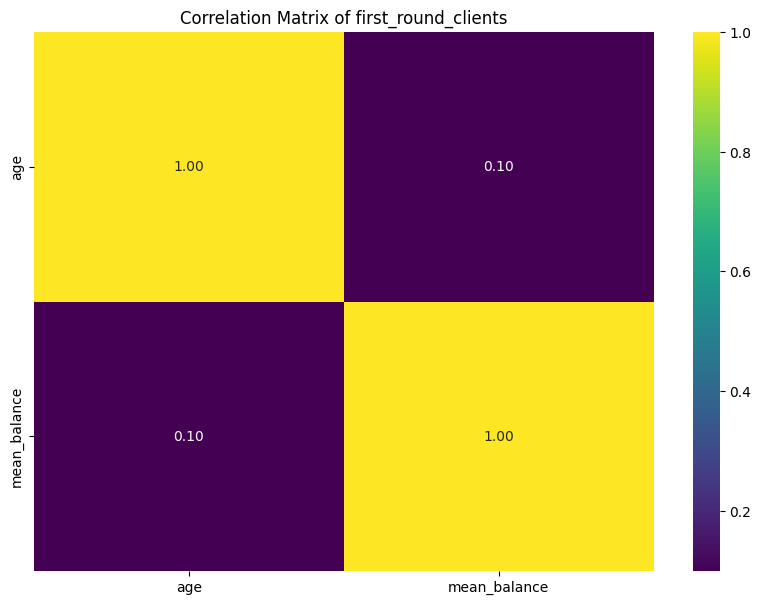

In [12]:
# Calculate the correlation matrix
matrix_data = first_round_clients[["age", "mean_balance"]]
correlation_matrix = matrix_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title('Correlation Matrix of first_round_clients')
plt.show()

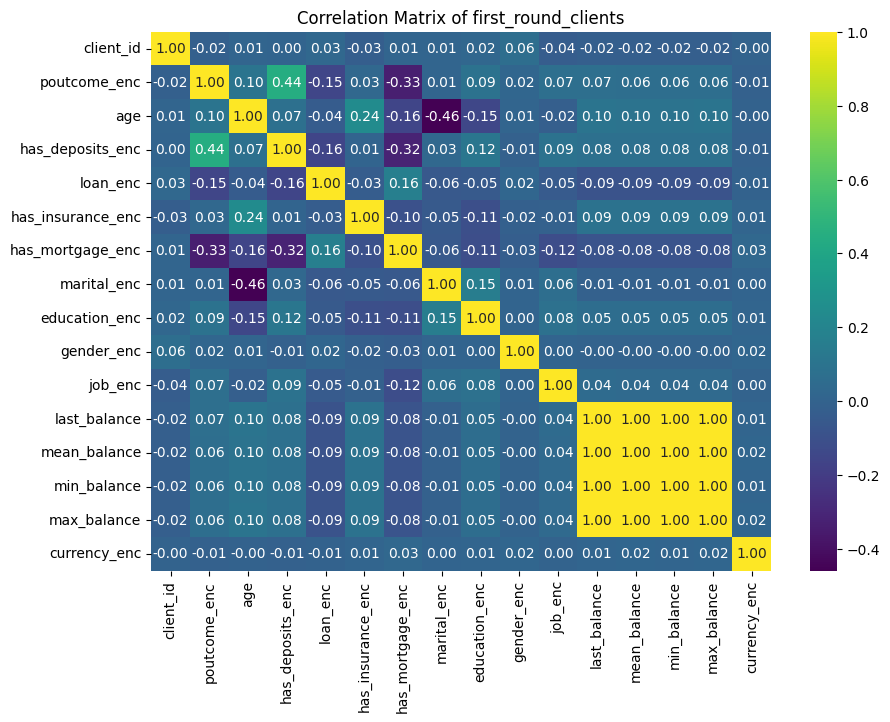

In [13]:
# Calculate the correlation matrix
correlation_matrix = first_round_clients.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)
plt.title('Correlation Matrix of first_round_clients')
plt.show()

In [14]:
first_round_clients.columns

Index(['client_id', 'poutcome_enc', 'age', 'has_deposits_enc', 'loan_enc',
       'has_insurance_enc', 'has_mortgage_enc', 'marital_enc', 'education_enc',
       'gender_enc', 'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance', 'currency_enc'],
      dtype='object')


Standardized Data:
        age  has_deposits_enc  loan_enc  has_insurance_enc  has_mortgage_enc  \
0 -0.316562          0.663684 -0.324482          -0.279875         -0.890669   
1 -0.316562         -1.506742  3.081837          -0.279875          1.122751   
2 -0.627179          0.663684  3.081837          -0.279875         -0.890669   
3  1.547141          0.663684 -0.324482          -0.279875         -0.890669   
4 -0.471871          0.663684 -0.324482          -0.279875         -0.890669   

   marital_enc  education_enc  gender_enc   job_enc  last_balance  \
0    -0.397171      -0.520767    1.019769  0.631154      0.278423   
1    -0.397171       0.864932    1.019769 -0.260868      1.111642   
2    -0.397171      -0.520767    1.019769  0.631154      0.354550   
3    -0.397171      -0.520767   -0.980614  0.036472      0.386360   
4     1.239203       0.864932    1.019769 -0.260868     -0.363623   

   mean_balance  min_balance  max_balance  currency_enc  
0      0.274664     0.2617

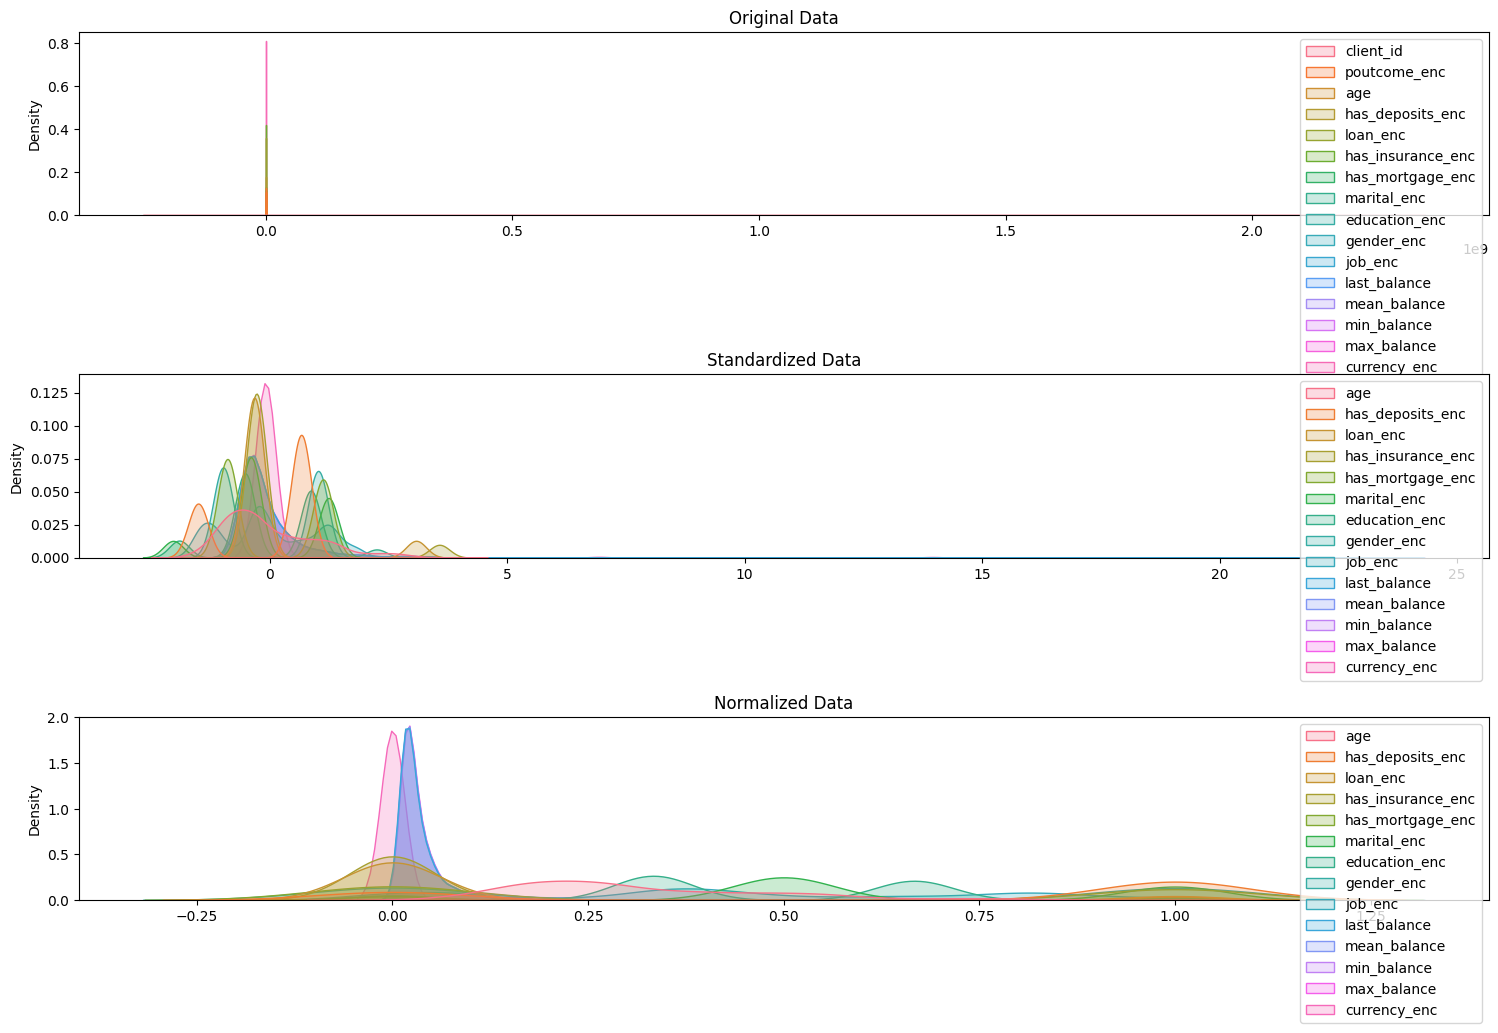

In [15]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'has_deposits_enc', 'loan_enc',
       'has_insurance_enc', 'has_mortgage_enc', 'marital_enc', 'education_enc',
       'gender_enc', 'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance', 'currency_enc']

columns_to_standardize = first_round_clients[features]

scaler = StandardScaler()

# Standardize the selected columns
iris_standardized = pd.DataFrame(scaler.fit_transform(columns_to_standardize), columns=features)
print("\nStandardized Data:")
print(iris_standardized.head())


# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler()

# Normalize the selected columns

iris_normalized = pd.DataFrame(min_max_scaler.fit_transform(columns_to_standardize), columns=features)
print("\nNormalized Data:")
print(iris_normalized.head())

# Plot original vs standardized vs normalized data for visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

sns.kdeplot(data=first_round_clients, ax=ax1, fill=True)
ax1.set_title("Original Data")

sns.kdeplot(data=iris_standardized, ax=ax2, fill=True)
ax2.set_title("Standardized Data")

sns.kdeplot(data=iris_normalized, ax=ax3, fill=True)
ax3.set_title("Normalized Data")

plt.tight_layout()
plt.show()


In [27]:
# Specify columns into features and prepare data for split
features = ['age', 'has_deposits_enc', 'loan_enc',
       'has_insurance_enc', 'has_mortgage_enc', 'marital_enc', 'education_enc',
       'gender_enc', 'job_enc', 'last_balance', 'mean_balance', 'min_balance',
       'max_balance', 'currency_enc']
X = first_round_clients[features]
y = first_round_clients["poutcome_enc"]

In [28]:
# Spliting table into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Show parametry in the X_train
X_train.shape

(1839, 14)

In [30]:
# Specify how it should look my model1. Need to encode!!!
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


# Specify how it should look my model2. No need to encode
model2 = Sequential([
    # input znamena kolik features mam v inputu. Tzn napriklad kolik sloupcu mam v inputu
    Input(shape = (14,)),
    Dense(32, activation = "tanh"),
    Dense(32, activation = "tanh"),
    Dense(1, activation = "sigmoid")

])

model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose = 0)


In [31]:
# Check accuracy of the model2
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

15/15 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5348
Test accuracy: 53.48%


15/15 [==============================] - 0s 2ms/step


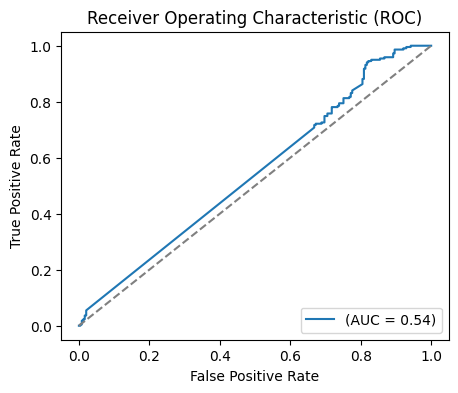

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, model2.predict(X_test)) #[:,1] for 2D output (model 1)
roc_auc = auc(fpr, tpr)

# plot line
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"(AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

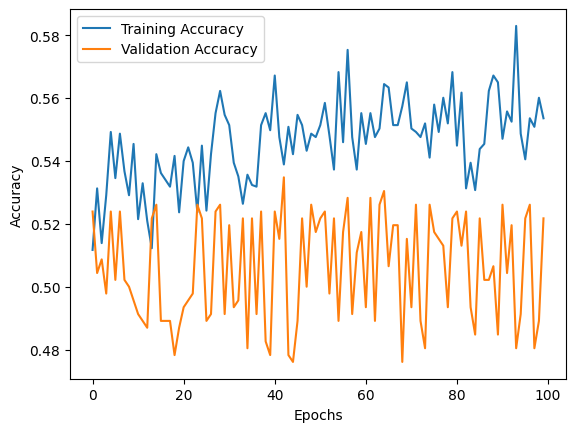

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

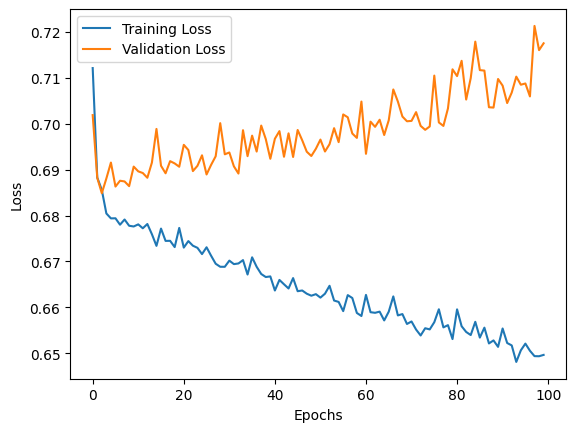

In [23]:
# Plot training loss vs. validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Random Forest Classifier:
Accuracy: 0.70


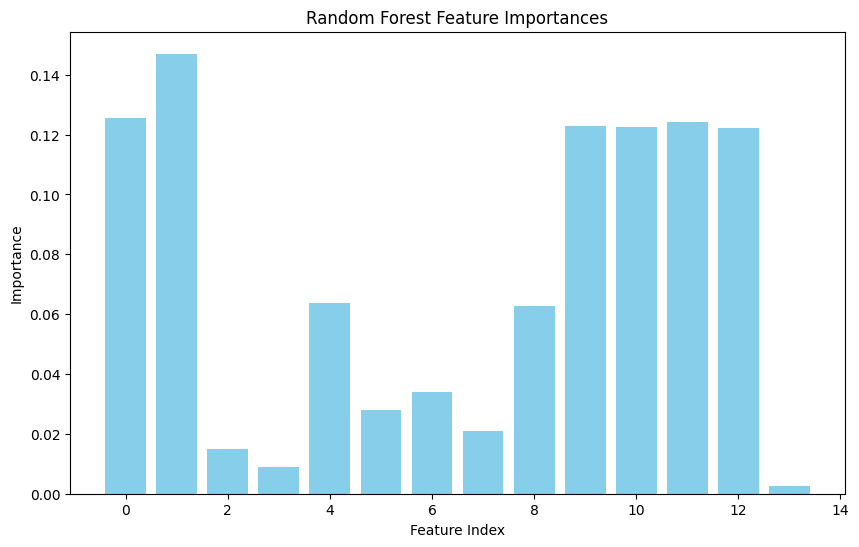


AdaBoost Classifier:
Accuracy: 0.71


In [24]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier = RandomForestClassifier(n_estimators=50, max_depth = 4)

# Fit and evaluate the Random Forest model
model3 = rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)

print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.2f}")

# Plot feature importances for the Random Forest
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': range(len(feature_importances)), 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

# For AdaBoost, since it doesn't have feature importances, we can print the accuracy over iterations
# Create an AdaBoost classifier with Decision Trees as base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Fit and evaluate the AdaBoost model
adaboost_classifier.fit(X_train, y_train)
adaboost_pred = adaboost_classifier.predict(X_test)

print("\nAdaBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, adaboost_pred):.2f}")



/Users/vojtechflidr/coding_bootcamp/DataScience-Course/case_study/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/vojtechflidr/coding_bootcamp/DataScience-Course/case_study/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/vojtechflidr/coding_bootcamp/DataScience-Course/case_study/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/vojtechflidr/coding_bootcamp/DataScience-Course/case_study/.venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


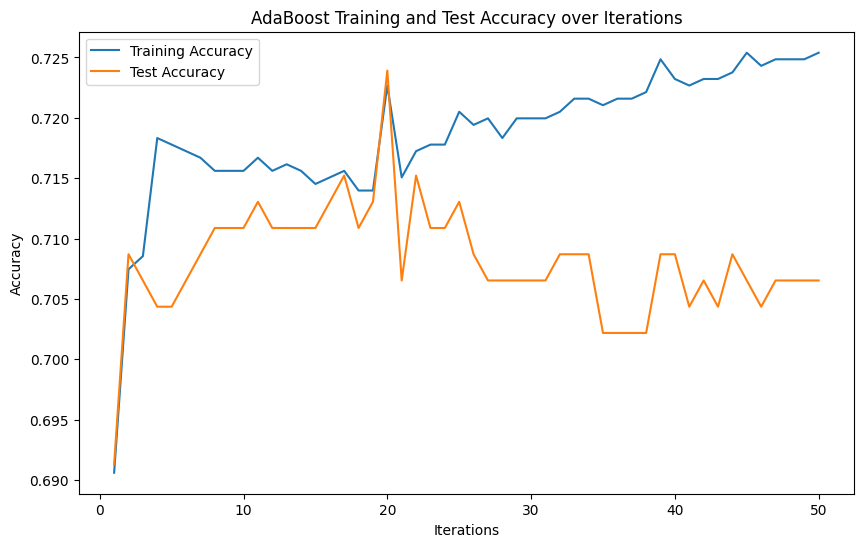

In [25]:
# For AdaBoost, print the accuracy over iterations
plt.figure(figsize=(10, 6))
# Convert the generator object to a list before plotting
test_accuracies = list(AdaBoostClassifier.staged_score(X_test, y_test))
train_accuracies = list(AdaBoostClassifier.staged_score(X_train, y_train))

plt.plot(range(1, 51), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), test_accuracies, label='Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('AdaBoost Training and Test Accuracy over Iterations')
plt.legend()
plt.show()